## Import

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from utils import *
from torch.autograd import Variable
import os
import numpy as np

## Check

In [2]:
check = torch.load('./data/adversarial/fgsm_0.pt')

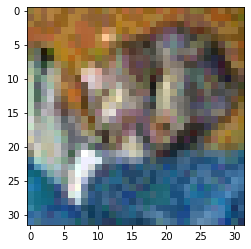

In [12]:
plt.imshow(check[0].detach().cpu().squeeze(0).permute(1, 2, 0))
plt.show()

## Model

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [3]:
model = load_model('./checkpoints/model.th')
model = model.to(device)

In [40]:
assert len(os.listdir('./data/adversarial')) == len(os.listdir('./data/normal'))
normal_data, targets = load_samples('./data/normal', 'fgsm')
print('Finish loading all normal examples')
adv_data, targets_ = load_samples('./data/adversarial', 'fgsm')
print('Finish loading all adversarial examples')
assert torch.sum(torch.eq(targets, targets_)).item() == len(targets)

0  examples are loaded
50  examples are loaded
Finish loading all normal examples
0  examples are loaded
50  examples are loaded
Finish loading all adversarial examples


In [41]:
def intermediate_feat(model, inputs, layer_ct):
    partial_mod = partial_model_execute(model, layer_ct)
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = partial_mod(inputs)
    output_feat = outputs.detach().cpu()
        
#         print(output_feat.shape)
    return output_feat

In [43]:
for lay in range(len(list(model.children()))):
    output_normal_feat = intermediate_feat(model, inputs=normal_data, layer_ct=lay)
    output_adv_feat = intermediate_feat(model, inputs=adv_data, layer_ct=lay)
    break

In [44]:
output_normal_feat = intermediate_feat(model, inputs=normal_data, layer_ct=9)
output_adv_feat = intermediate_feat(model, inputs=adv_data, layer_ct=9)

In [45]:
print(output_adv_feat.shape)

torch.Size([100, 512, 1, 1])


In [54]:
len(output_adv_feat)

100

In [58]:
normal_mean = []
adv_mean = []
normal_var = []
adv_var = []
diff_list = []

for i in range(len(output_adv_feat)): # loop over all samples
    normal_var.append(np.std(output_normal_feat[i].flatten().numpy()))
    normal_mean.append(np.mean(output_normal_feat[i].flatten().numpy()))
    
    adv_var.append(np.std(output_adv_feat[i].flatten().numpy()))
    adv_mean.append(np.mean(output_adv_feat[i].flatten().numpy()))
    
    feature_map_diff = output_normal_feat[i].flatten().numpy() - output_adv_feat[i].flatten().numpy()
    diff_list.append(feature_map_diff)

diff_list = np.asarray(diff_list)

In [59]:
diff_list.shape

(100, 512)

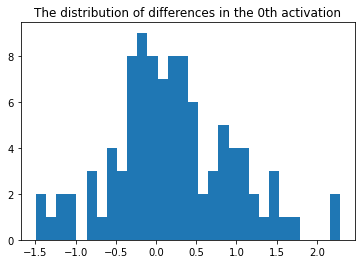

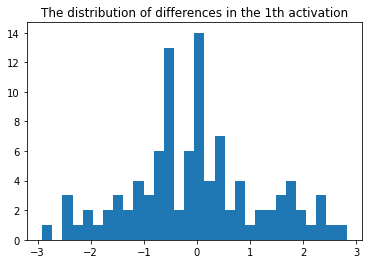

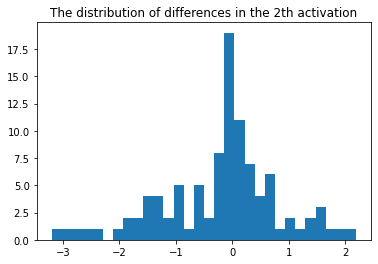

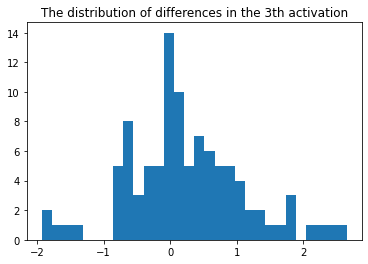

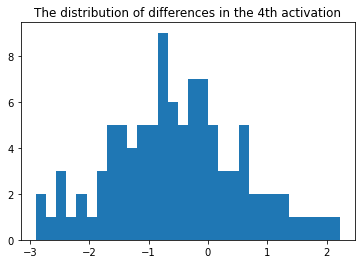

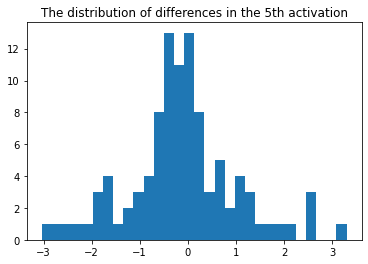

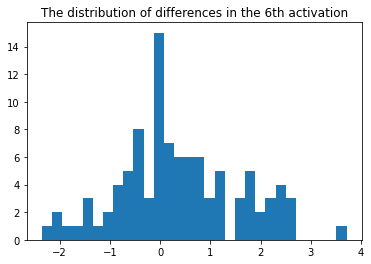

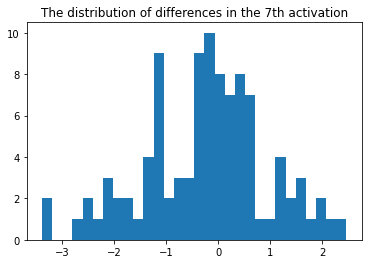

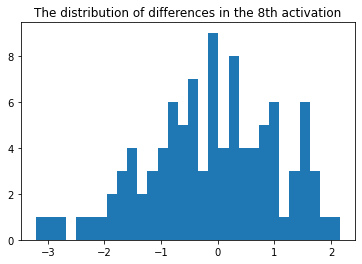

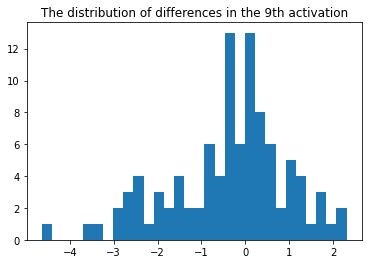

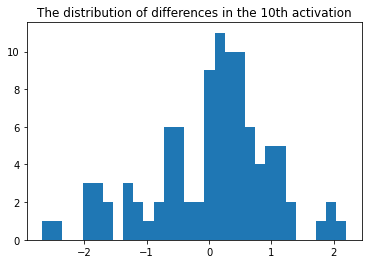

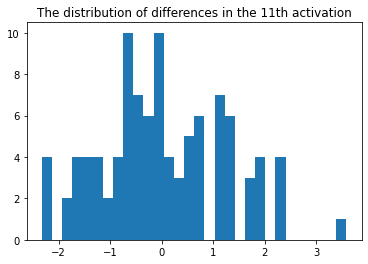

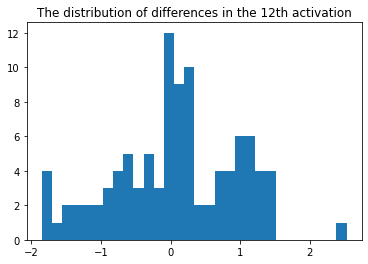

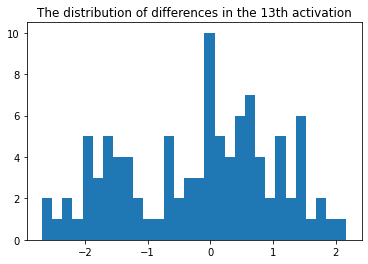

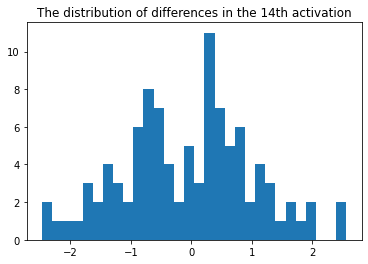

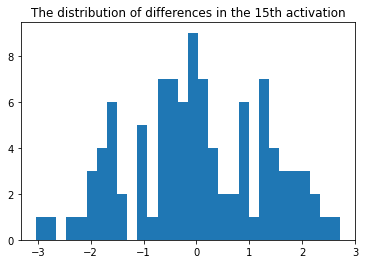

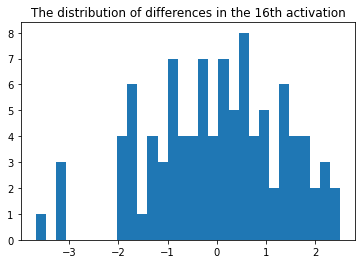

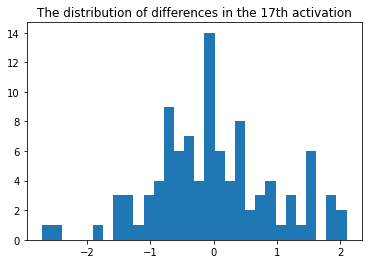

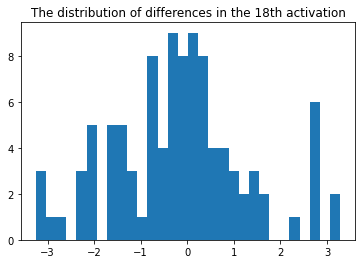

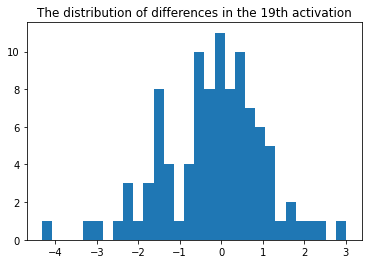

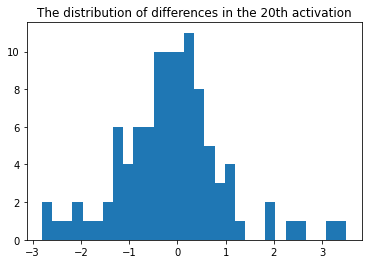

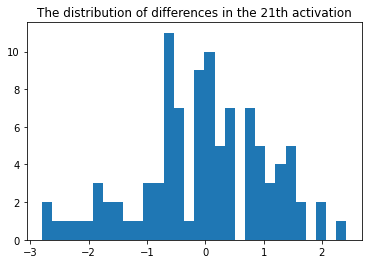

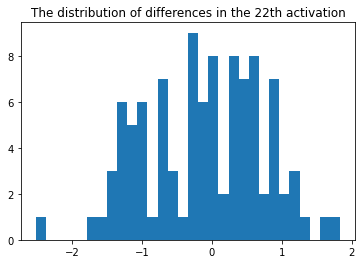

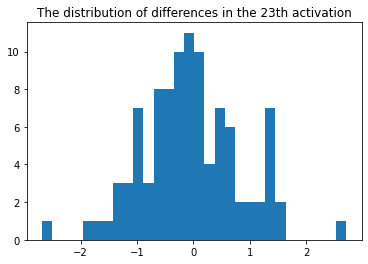

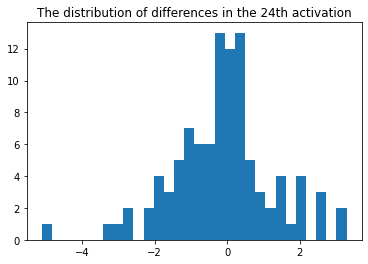

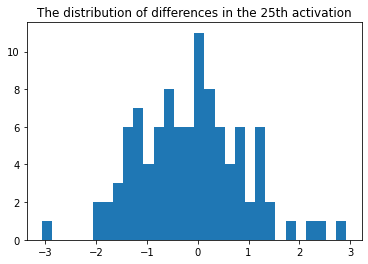

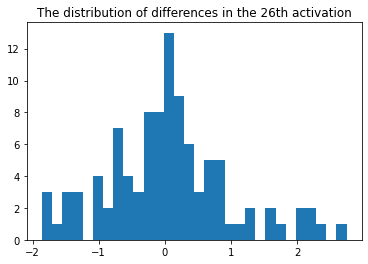

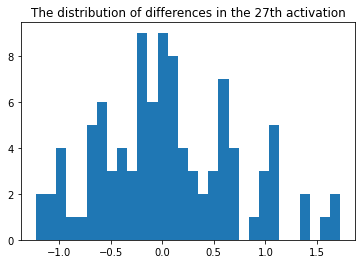

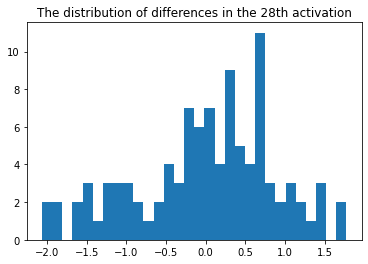

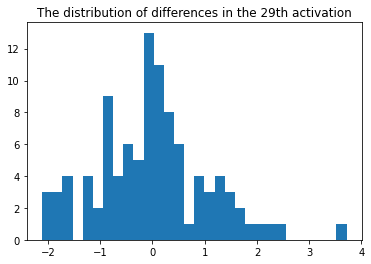

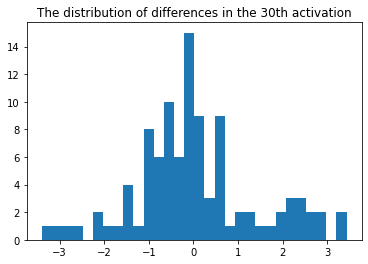

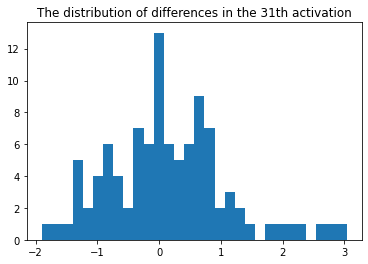

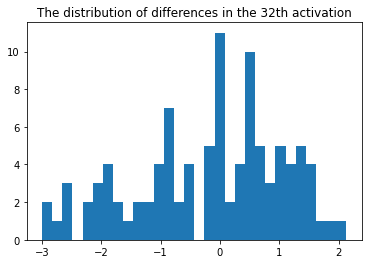

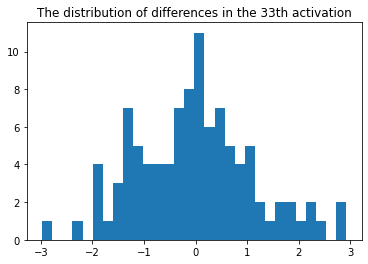

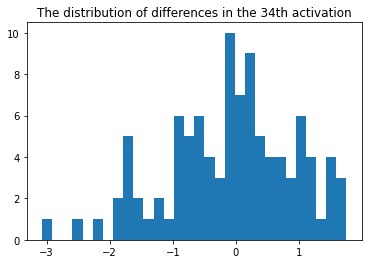

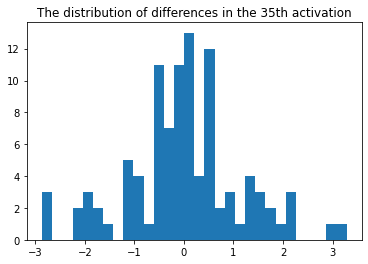

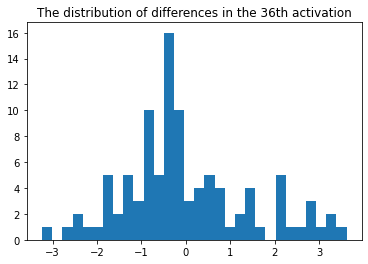

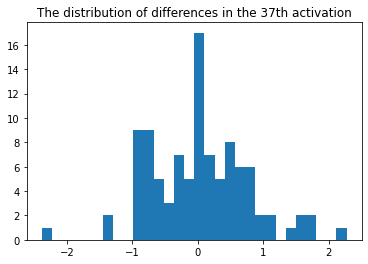

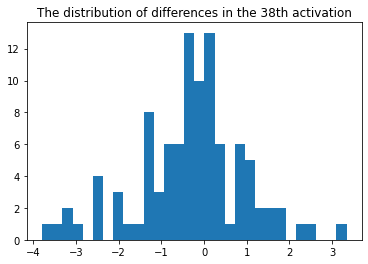

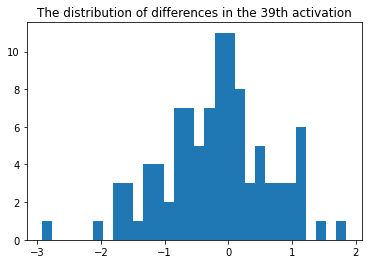

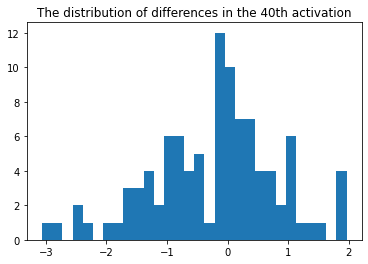

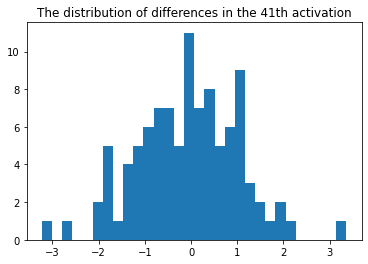

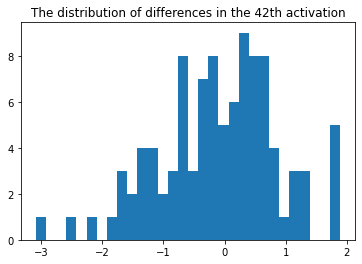

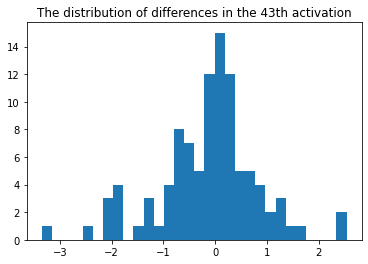

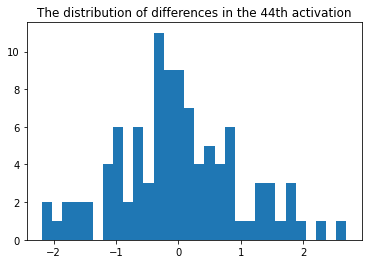

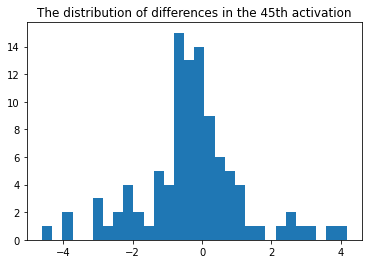

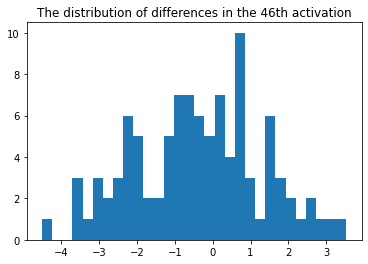

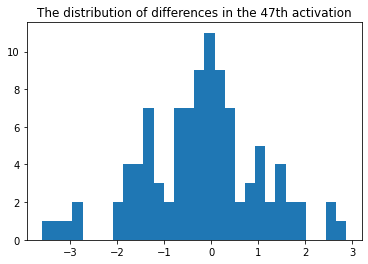

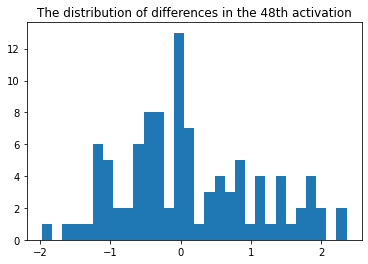

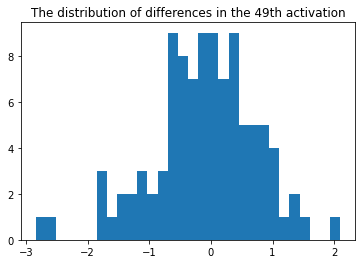

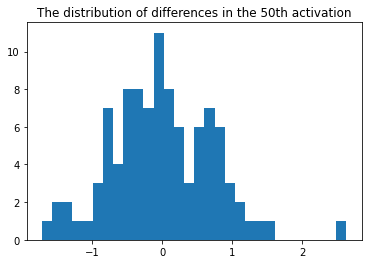

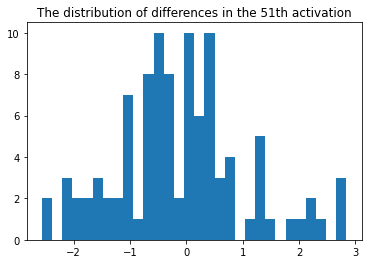

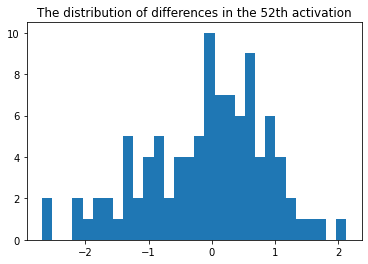

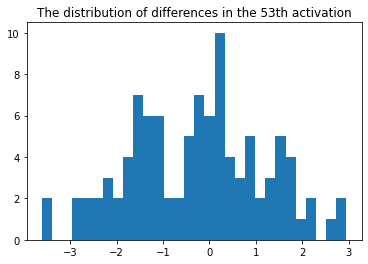

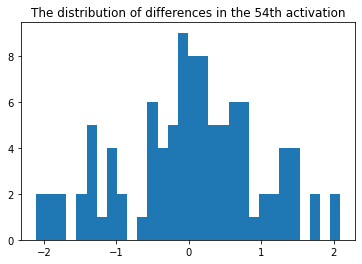

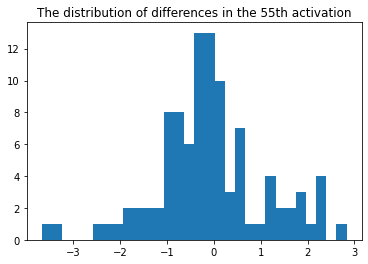

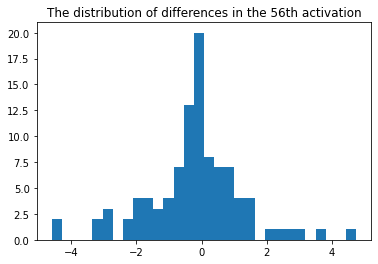

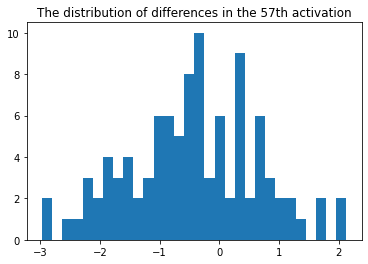

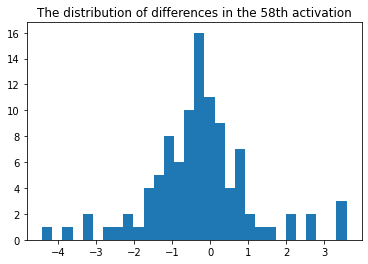

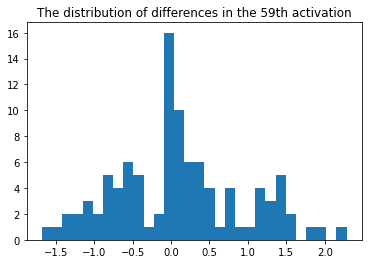

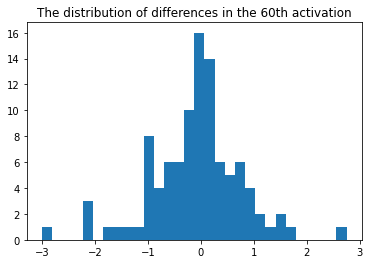

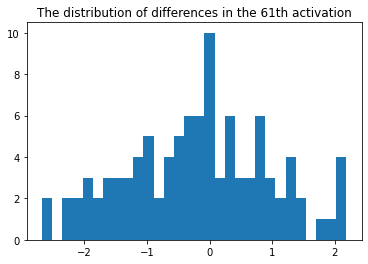

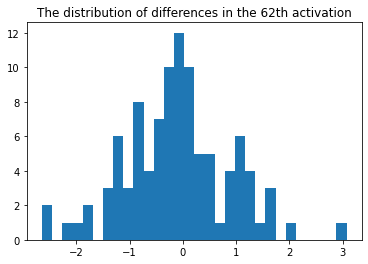

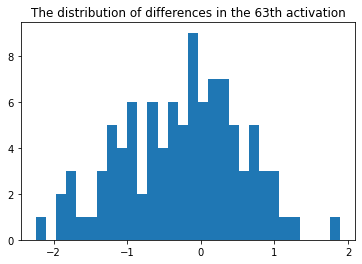

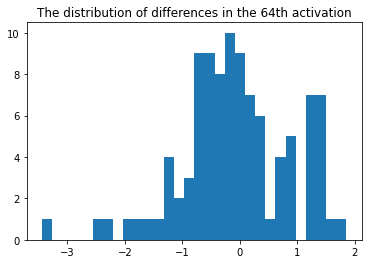

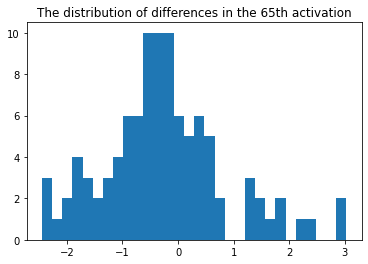

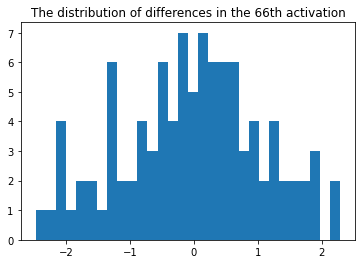

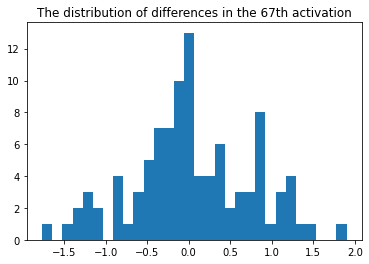

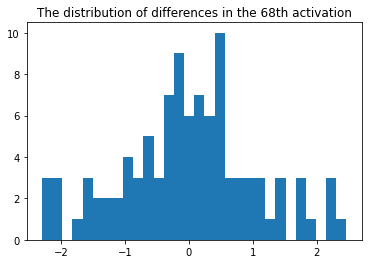

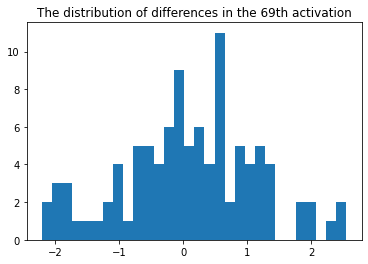

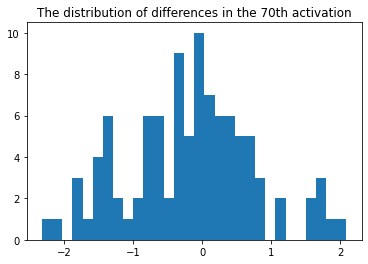

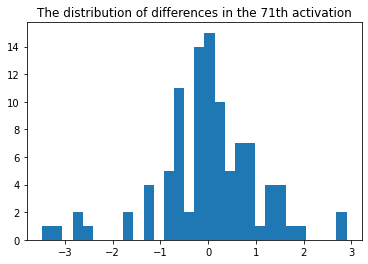

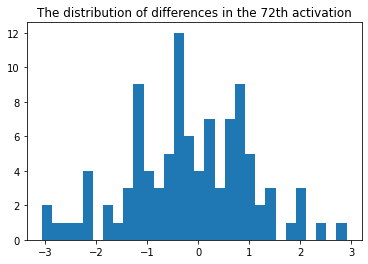

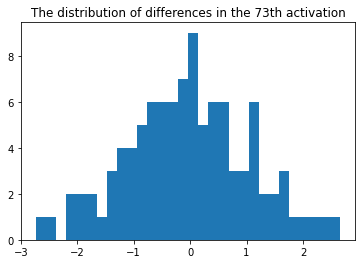

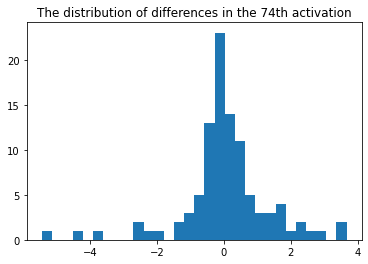

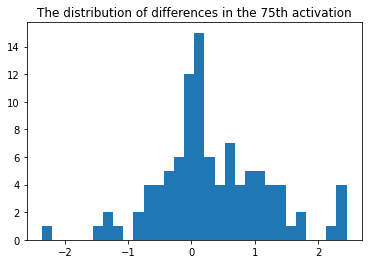

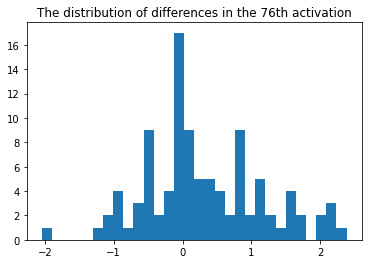

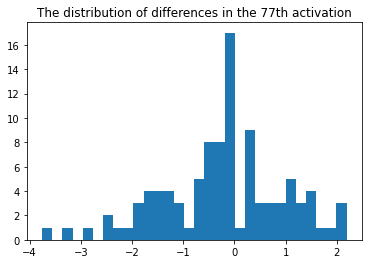

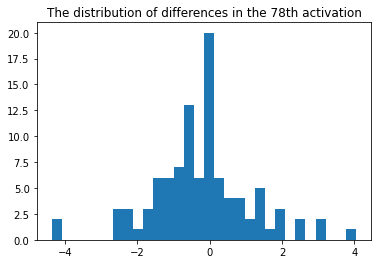

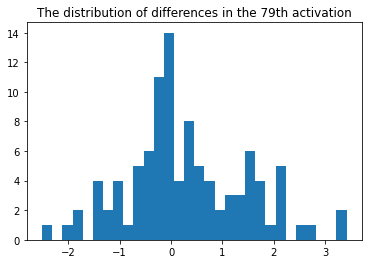

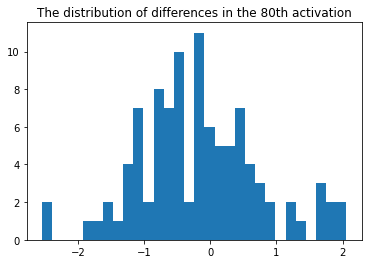

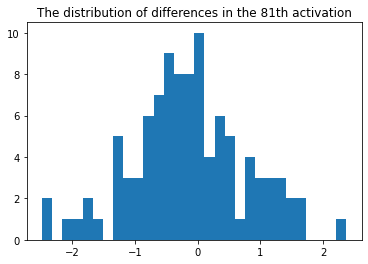

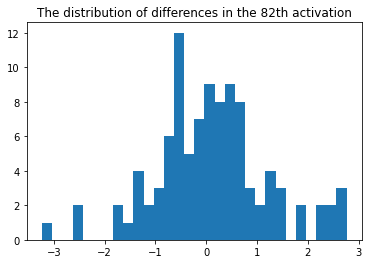

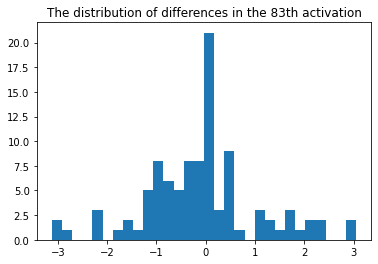

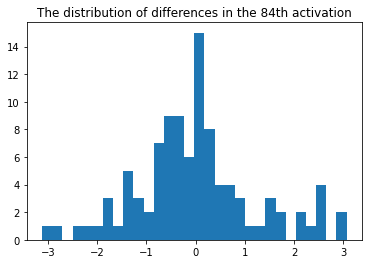

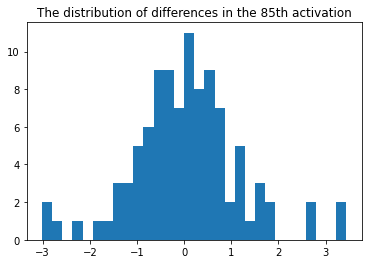

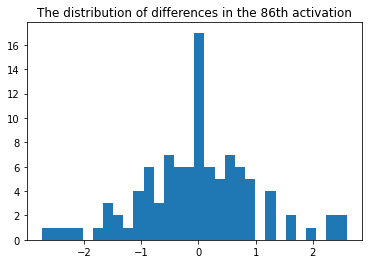

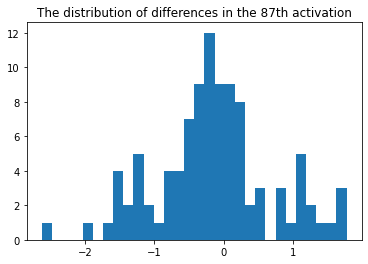

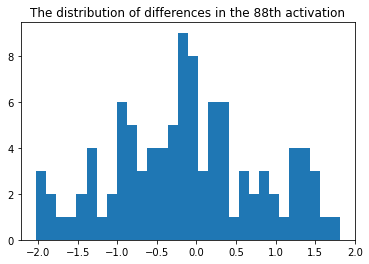

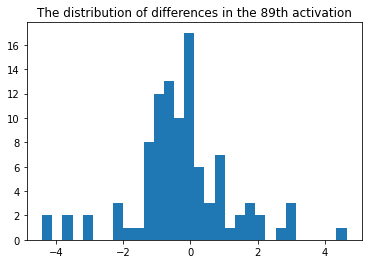

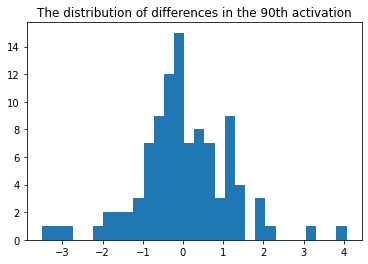

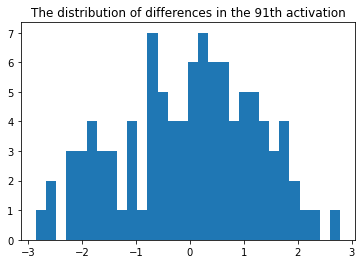

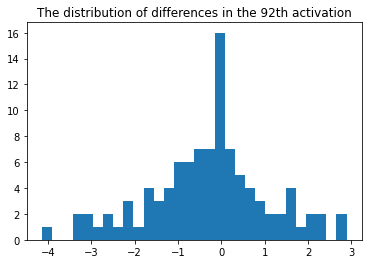

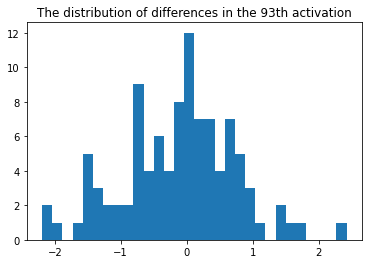

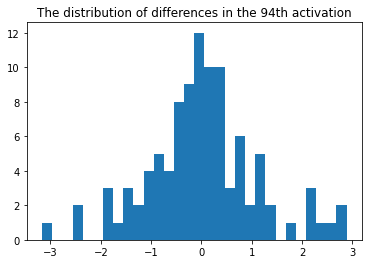

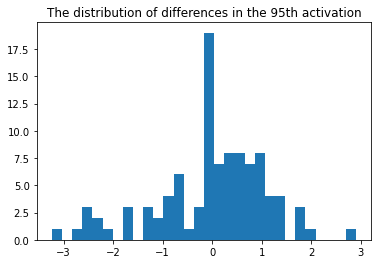

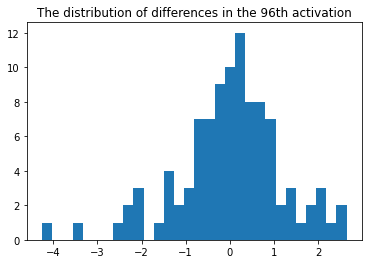

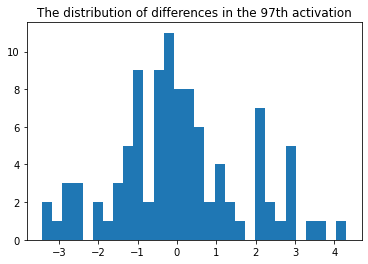

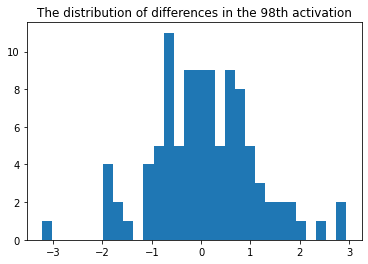

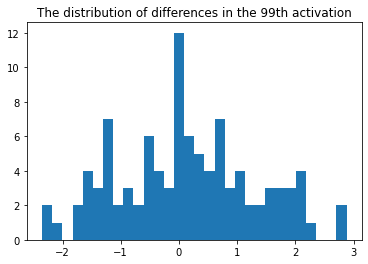

In [61]:
for i in range(100):
    plt.hist(diff_list[:, i], bins=30)
    plt.title('The distribution of differences in the {}th activation'.format(i))
    plt.show()

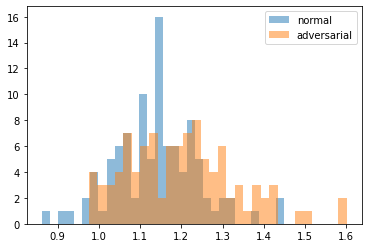

In [53]:
plt.hist(normal_mean, bins=30, alpha=0.5, label='normal')
plt.hist(adv_mean, bins=30, alpha=0.5, label='adversarial')
plt.legend()
plt.show()

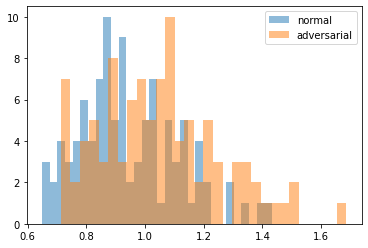

In [52]:
plt.hist(normal_var, bins=30, alpha=0.5, label='normal')
plt.hist(adv_var, bins=30, alpha=0.5, label='adversarial')
plt.legend()
plt.show()